In [718]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

import warnings

from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import roc_curve,roc_auc_score,f1_score,accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

In [719]:
warnings.filterwarnings(action = 'ignore')

In [720]:
rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

# Classifier 문제 Ensemble Bagging 

### Classifier 문제에서 Bagging이 효과적인 이유 

In [721]:
X, y = make_classification(n_samples = 1000, n_features=2, n_informative=2, n_redundant=0, n_classes=2,
                            random_state = 55, flip_y = 0.3)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  


Text(0.5, 1.0, 'Data')

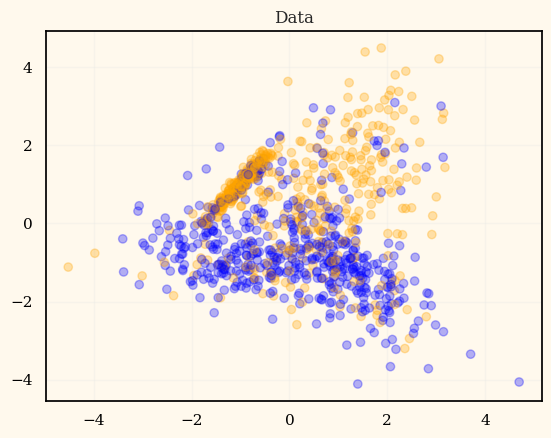

In [722]:
cmap = ['orange' if label == 1 else 'blue' for label in y]


plt.scatter(X[:,0], X[:,1], c = cmap, alpha = 0.3)
plt.title('Data')

In [723]:
rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
xgb = XGBClassifier(n_estimators = 10, random_state = 42)
lgb = LGBMClassifier(n_estimators = 10, verbose = -1, random_state = 42)
svc = SVC(probability = True)
logist = LogisticRegression(C = 1)
knn = KNeighborsClassifier()

models = [rf,xgb,lgb,svc,logist,knn]

models_name = ['RandomForestClassifier', 'XGBClassifier', 'LGBMClassifier',
                'SVC','LogisticRegression', 'KNeighborsClassifier']

Text(0.5, 0.98, 'Predicted Result by Classifier model')

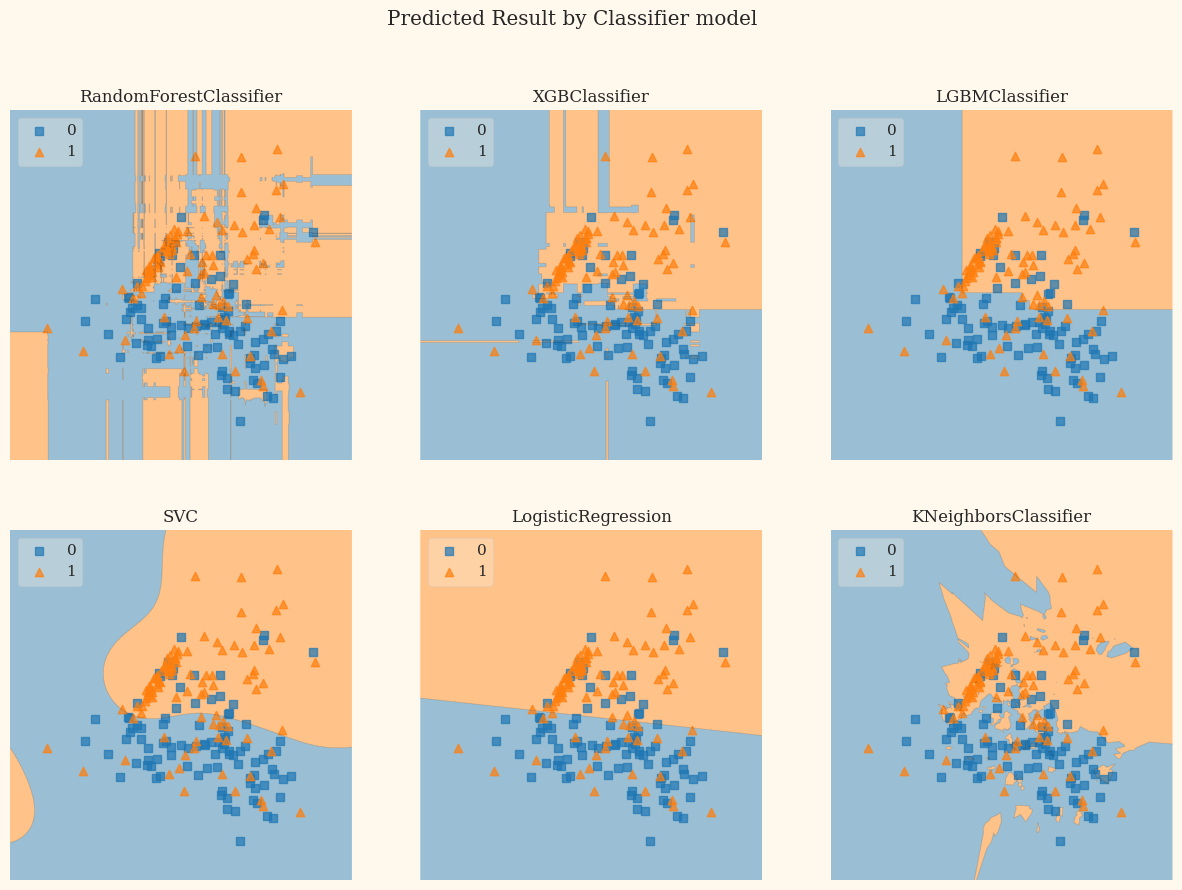

In [724]:
fig,ax = plt.subplots(ncols = 3, nrows = 2, figsize = (15,10))
ax = ax.flatten()

y_train,y_test = np.array(y_train),np.array(y_test)

scatter_kwargs = {'edgecolor': None, 'alpha': 0.7}
contourf_kwargs = {'alpha': 0.2}


for i,model in enumerate(models):
    
    model.fit(x_train,y_train)
    plot_decision_regions(x_test,y_test,clf = model,
                            legend = 2,
                            scatter_kwargs = scatter_kwargs,
                            contour_kwargs = contourf_kwargs,
                            ax = ax[i])
    
    ax[i].set_title(models_name[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.suptitle('Predicted Result by Classifier model')

##### 단일 모델의 accuracy 

In [725]:
proba_list = [np.zeros((len(y_test),1)) for _ in range(len(models))] # model 별 proba 값을 담아줄 list 

for i,model in enumerate(models):
    
    model.fit(x_train,y_train)
    proba_list[i] += model.predict_proba(x_test)[:,1].reshape(-1,1)

In [726]:
for i,proba in enumerate(proba_list):
    
    pred = (proba > 0.5).astype(int)
    
    score = round(accuracy_score(y_test, pred), 3)
    
    print(f'{models_name[i]} 의 accuracy : {score}')

RandomForestClassifier 의 accuracy : 0.75
XGBClassifier 의 accuracy : 0.785
LGBMClassifier 의 accuracy : 0.77
SVC 의 accuracy : 0.765
LogisticRegression 의 accuracy : 0.77
KNeighborsClassifier 의 accuracy : 0.77


# Simple Ensemble 

##### model 별 가중치를 두지 않고 단순 평균으로 앙상블 

In [727]:
class SimpleEnsembleModel:
    
    def __init__(self,models, method):
        
        self.models = models
        self.fitted_models = []
        self.method = method
        
    def fit(self,X,y):
        
        self.X = X
        self.y = y
        
        self.fitted_models = [model.fit(self.X,self.y) for model in self.models]
        
    def predict(self,test):
            
        if self.method == 'soft':
                
            probas = [model.predict_proba(test)[:,1] for model in self.fitted_models]
            
            ensemble_pred = (np.mean(probas,axis = 0) > 0.5).astype(int)
            
        if self.method == 'hard':
            
            pred_list = np.zeros(len(test))
            
            for model in self.fitted_models:
                
                pred_list += model.predict(test)
                
            ensemble_pred = np.where(pred_list >= len(self.fitted_models) /2 , 1,0)
            
            
            
        return ensemble_pred

In [728]:
ensemble_model = SimpleEnsembleModel(models, 'soft')
ensemble_model.fit(x_train,y_train)

ensemble_pred = (ensemble_model.predict(x_test)> 0.5).astype(int)

ensemble_score = round(accuracy_score(y_test,ensemble_pred),2)

print(f'Simple Ensemble model 의 Accuracy : {ensemble_score}')

Simple Ensemble model 의 Accuracy : 0.79


Text(0.5, 0.98, 'Deicision Region')

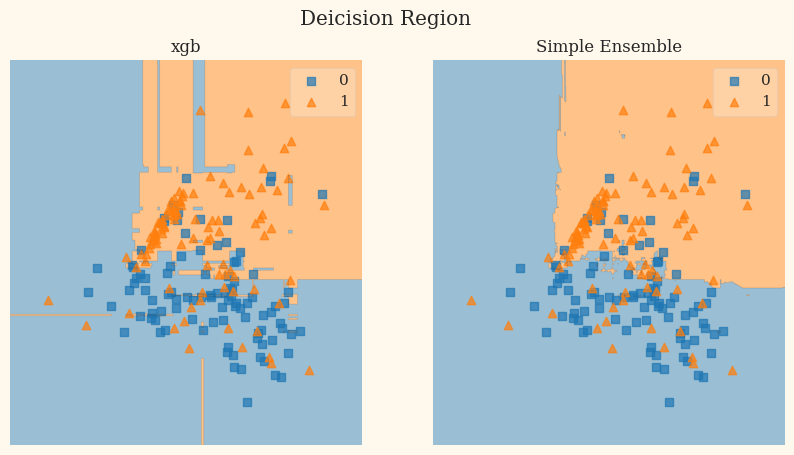

In [734]:
# 단일 모델 중 가장 성능이 좋았던 lightgbm과의 차이를 살펴보자 

fig,ax = plt.subplots(ncols = 2, figsize = (10,5))

xgb.fit(x_train,y_train)

plot_decision_regions(x_test,y_test,clf = xgb,
                        scatter_kwargs = scatter_kwargs,
                        contour_kwargs = contourf_kwargs,
                        ax = ax[0])
ax[0].set_title('xgb')
ax[0].set_xticks([])
ax[0].set_yticks([])


plot_decision_regions(x_test,y_test,clf = ensemble_model,
                        scatter_kwargs = scatter_kwargs,
                        contour_kwargs = contourf_kwargs,
                        ax = ax[1])
ax[1].set_title('Simple Ensemble')
ax[1].set_xticks([])
ax[1].set_yticks([])

fig.suptitle('Deicision Region')

# 가중치를 둔 Ensemble 

In [730]:
class WeightedEnsembleModel:
    
    def __init__(self,models, splits, random_state):
        
        self.models = models
        self.fitted_models = []
        self.weight_list = [0 for _ in range(len(self.models))]
        self.normalized_list = [0 for _ in range(len(self.models))]
        self.splits = splits
        self.cv = KFold(n_splits = splits, random_state = random_state,
                        shuffle = True)
        
    def fit(self,X,y):
        
        self.X = X
        self.y = y
        
        for i,model in enumerate(self.models):    
            for train_idx,test_idx in self.cv.split(self.X,self.y):
                
                x_train,y_train = self.X[train_idx],self.y[train_idx]
                x_valid,y_valid = self.X[test_idx], self.y[test_idx]
                
                model.fit(x_train,y_train)
                pred = model.predict(x_valid)
                self.weight_list[i] += accuracy_score(y_valid, pred) / self.splits
                

        total_weight = np.sum(self.weight_list)
        
        for i,w in enumerate(self.weight_list):
            
            self.normalized_list[i] += w / total_weight
            

        self.fitted_models = [model.fit(self.X,self.y) for model in models]
        

        
    def predict(self,test):
                
        probas = [model.predict_proba(test)[:,1] * self.normalized_list[i] for i,model in enumerate(self.fitted_models)]
        
        ensemble_proba = np.sum(probas,axis = 0)
        
        return ensemble_proba

In [731]:
weighted_ensemble = WeightedEnsembleModel(models, splits = 5, random_state = 42)
weighted_ensemble.fit(x_train,y_train)
pred = (weighted_ensemble.predict(x_test) > 0.5).astype(int) 

In [733]:
weighted_ensemble_score = round(accuracy_score(y_test,pred),3)

print(f'Weighted Ensemble 모델의 Accuracy : {weighted_ensemble_score}')

Weighted Ensemble 모델의 Accuracy : 0.79


Text(0.5, 0.98, 'Deicision Region')

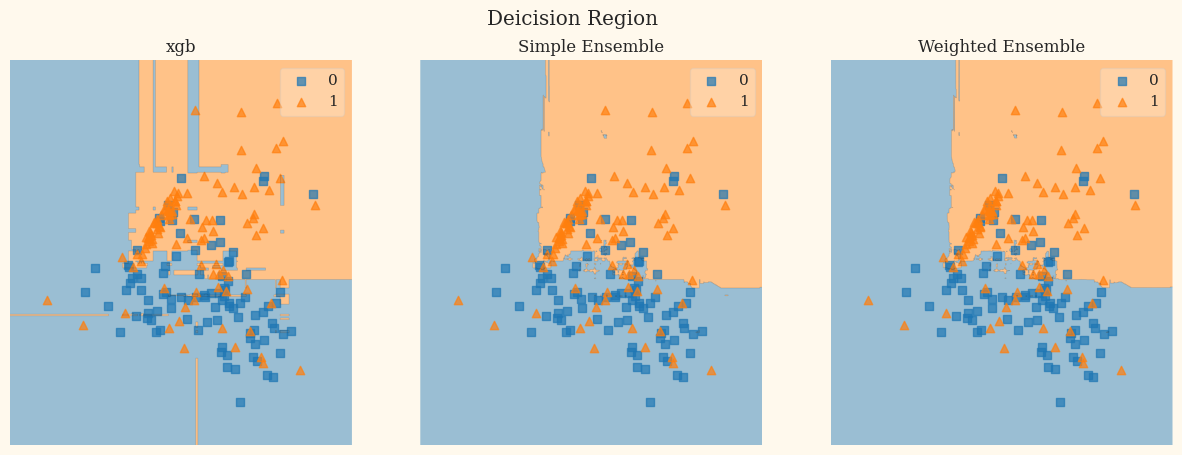

In [735]:
# 단일 모델 중 가장 성능이 좋았던 lightgbm과의 차이를 살펴보자 

fig,ax = plt.subplots(ncols = 3, figsize = (15,5))

xgb.fit(x_train,y_train)

plot_decision_regions(x_test,y_test,clf = xgb,
                        scatter_kwargs = scatter_kwargs,
                        contour_kwargs = contourf_kwargs,
                        ax = ax[0])
ax[0].set_title('xgb')
ax[0].set_xticks([])
ax[0].set_yticks([])


plot_decision_regions(x_test,y_test,clf = ensemble_model,
                        scatter_kwargs = scatter_kwargs,
                        contour_kwargs = contourf_kwargs,
                        ax = ax[1])
ax[1].set_title('Simple Ensemble')
ax[1].set_xticks([])
ax[1].set_yticks([])

plot_decision_regions(x_test,y_test,clf = weighted_ensemble,
                        scatter_kwargs = scatter_kwargs,
                        contour_kwargs = contourf_kwargs,
                        ax = ax[2])

ax[2].set_title('Weighted Ensemble')
ax[2].set_xticks([])
ax[2].set_yticks([])


fig.suptitle('Deicision Region')